In [ ]:
pip install yfinance statsmodels pandas numpy matplotlib

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Predicted stock price for GS on the next day: $618.44


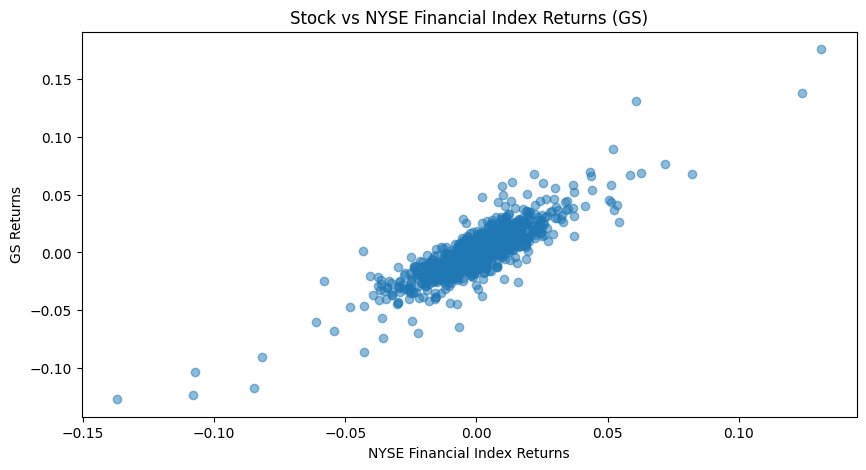

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Download historical data for a stock and the NYSE Financial Index (ETF XLF)
def get_data(stock_ticker, start_date, end_date):
    try:
        # Download stock and financial index data using XLF ETF
        stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
        financial_index_data = yf.download('XLF', start=start_date, end=end_date)  # Use XLF for Financial Index ETF

        if stock_data.empty or financial_index_data.empty:
            raise ValueError("Data download failed or returned empty dataframe.")

        # Calculate daily returns
        stock_data['Return'] = stock_data['Close'].pct_change()
        financial_index_data['Return'] = financial_index_data['Close'].pct_change()

        return stock_data, financial_index_data

    except Exception as e:
        print(f"Error downloading data: {e}")
        return None, None

# Calculate rolling volatility (standard deviation) for stock and financial index
def calculate_volatility(data, window=21):
    return data.rolling(window).std()

# Perform regression to find the relationship between stock and NYSE Financial Index (with lags and volatility)
def run_regression(stock_data, financial_index_data):
    # Align the data based on dates
    data = pd.concat([stock_data['Return'], financial_index_data['Return']], axis=1)
    data.columns = ['Stock_Return', 'XLF_Return']
    data = data.dropna()  # Drop missing values

    # Add lagged terms for stock and XLF (NYSE Financial Index)
    data['Lagged_Stock_Return'] = data['Stock_Return'].shift(1)  # Lagged stock return
    data['Lagged_XLF_Return'] = data['XLF_Return'].shift(1)  # Lagged XLF return
    data = data.dropna()  # Drop rows with missing lagged values

    # Calculate rolling volatility
    data['Stock_Volatility'] = calculate_volatility(stock_data['Return'])
    data['XLF_Volatility'] = calculate_volatility(financial_index_data['Return'])

    # Drop rows with NaN values in volatility columns
    data = data.dropna()

    # Add constant (intercept) for regression model
    X = sm.add_constant(data[['Lagged_Stock_Return', 'Lagged_XLF_Return', 'Stock_Volatility', 'XLF_Volatility']])
    y = data['Stock_Return']

    # Perform the regression
    model = sm.OLS(y, X).fit()

    return model

# Predict next day's stock price using the regression model
def predict_next_day(stock_data, model):
    # Get the most recent return and volatility values
    last_xlf_return = stock_data['Return'].iloc[-1]
    last_stock_return = stock_data['Return'].iloc[-1]
    last_stock_volatility = calculate_volatility(stock_data['Return']).iloc[-1]
    last_xlf_volatility = calculate_volatility(stock_data['Return']).iloc[-1]

    # Calculate the predicted stock return using the regression model
    predicted_stock_return = model.predict([1, last_stock_return, last_xlf_return, last_stock_volatility, last_xlf_volatility])[0]

    # Get the last stock price
    last_stock_price = stock_data['Close'].iloc[-1]

    # Predict the stock price for the next day
    predicted_stock_price = last_stock_price * (1 + predicted_stock_return)

    return predicted_stock_price

# Main function to run the model
def main(stock_ticker, start_date, end_date):
    # Get the historical data
    stock_data, financial_index_data = get_data(stock_ticker, start_date, end_date)

    if stock_data is None or financial_index_data is None:
        print("Error: Data not available. Exiting.")
        return

    # Run regression to get the relationship (beta) between the stock and the NYSE Financial Index
    model = run_regression(stock_data, financial_index_data)

    # Predict the stock price for the next day
    predicted_price = predict_next_day(stock_data, model)

    # Ensure the predicted price is a scalar (not a Pandas Series)
    predicted_price = predicted_price.item()  # Convert from Series to scalar

    # Print the results
    print(f"Predicted stock price for {stock_ticker} on the next day: ${predicted_price:.2f}")

    # Optional: Plot the historical returns of stock vs NYSE Financial Index
    plt.figure(figsize=(10, 5))
    plt.scatter(financial_index_data['Return'], stock_data['Return'], alpha=0.5)
    plt.title(f"Stock vs NYSE Financial Index Returns ({stock_ticker})")
    plt.xlabel('NYSE Financial Index Returns')
    plt.ylabel(f'{stock_ticker} Returns')
    plt.show()

# Example: Predict the stock price of Goldman Sachs (GS) based on the historical data of the NYSE Financial Index
if __name__ == '__main__':
    stock_ticker = 'GS'  # Example: Goldman Sachs stock
    start_date = '2020-01-01'
    end_date = '2025-03-01'

    main(stock_ticker, start_date, end_date)